<a href="https://colab.research.google.com/github/marko20014/skills-introduction-to-github/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics torchinfo


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from zipfile import ZipFile
import time
import os
import torchmetrics
from torchinfo import summary
from IPython.display import clear_output

In [ ]:
# Unzip the file
# Dataset link: https://www.kaggle.com/datasets/mstjebashazida/affectnet

with ZipFile('/content/drive/MyDrive/affectnet.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/affectnet')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
pip install graphsmote

In [ ]:
# Hyperparameters

# Training Parameters
num_epochs = 30
lr = 1e-4
batch_size = 64

# Early stopping Parameters
patience = 5          # Number of epochs to wait for improvement


In [ ]:
# Image Data Augementation

train_transforms = v2.Compose([
    v2.Resize(224),
    #v2.RandomHorizontalFlip(),
    #v2.RandomRotation(20),
    #v2.ColorJitter(0.1, 0.1, 0.1, 0.1),
    #v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = v2.Compose([
    v2.Resize(140),
    v2.CenterCrop(128),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# Datasets
train_root = '/content/affectnet/affectnet/Train'
test_root = '/content/affectnet/affectnet/Test'

# Get Train data without transforms
total_train = ImageFolder(root=train_root)

# set train and test sizes
train_size = int(0.8 * len(total_train))
val_size = len(total_train) - train_size

# Set a seed for reproducibility
generator = torch.Generator().manual_seed(42)

# splits
train_subset, valid_subset = random_split(total_train, [train_size, val_size], generator=generator)


In [ ]:
# Create a Custom Dataset class to transform the subsets
class CustomDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.subset)

# Apply corresponding transforms
train_data = CustomDataset(train_subset, train_transforms)
valid_data   = CustomDataset(valid_subset, valid_transforms)

In [ ]:
test_data = ImageFolder(root=test_root, transform=valid_transforms)

In [ ]:
print(f'Train: {len(train_data)},  Valid: {len(valid_data)}, Test: {len(test_data)}')

Train: 12886,  Valid: 3222, Test: 14518


In [ ]:
# Dataloader

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [ ]:
images, labels = next(iter(train_dataloader))

In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
print(len(train_dataloader), len(valid_dataloader), len(test_dataloader))

202 51 227


In [ ]:
def normalize_img(img):
   # Get the minimum and maximum pixel values across height and width, for each channel
    min_vals = img.min(dim=1, keepdim=True)[0].min(dim=2, keepdim=True)[0]
    max_vals = img.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]

    # Normalize each channel to [0, 1]
    return (img - min_vals) / (max_vals - min_vals + 1e-8)  # add epsilon to avoid division by zero



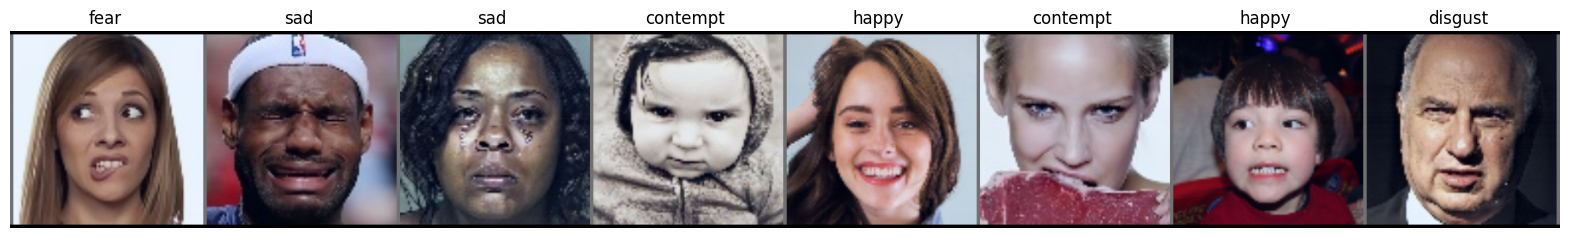

In [ ]:
# Set up a figure for displaying images
plt.figure(figsize=(20, 10))

# Get class names from the dataset
class_names = total_train.classes

# Select the first 8 images and their corresponding labels
selected_images = images[:8]
selected_labels = labels[:8]

# Create a grid of images (adds padding between them)
grid = torchvision.utils.make_grid(selected_images, padding=4)

# Convert to NumPy and rearrange dimensions for display (C, H, W) → (H, W, C)
img_np = grid.numpy().transpose((1, 2, 0))

# Convert the NumPy array back to a PyTorch tensor before normalizing
img_tensor = torch.from_numpy(img_np)

# Normalize image to [0, 1] for display
plt.imshow(normalize_img(img_tensor))

# Add class label text above each image
for i, label in enumerate(selected_labels):
    plt.text(i * (224 + 4) + 224 / 2, -10, class_names[label], ha='center', fontsize=12, color='black')

plt.axis('off')  # Hide axes
plt.show()


In [ ]:
# Splits a feature map into non-overlapping patches (implemented as a 2D conv with kernel_size = stride = patch_size),
# then flattens and transposes so that each patch becomes a vector of length 'embed_dim.
class PatchEmbed(nn.Module):
    def __init__(self, in_channels=512, embed_dim=256, patch_size=1):
        super().__init__()
        # A 1×1 conv that projects from in_channels -> embed_dim for each patch
        self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # x: (B, in_channels, H, W)
        x = self.proj(x)         # -> (B, embed_dim, H', W') where H' = H/patch_size, W' = W/patch_size
        x = x.flatten(2)          # -> (B, embed_dim, H'*W')
        x = x.transpose(1, 2)      # -> (B, num_patches, embed_dim), num_patches = H'*W'
        return x


class MiniViT(nn.Module):
    def __init__(self, in_channels=512, embed_dim=256, num_layers=6, num_heads=8,
                 dropout=0.1, dim_feedforward=1024, patch_size=1, max_num_patches=1000):
        super().__init__()

        # Patch embedding layer
        self.patch_embed = PatchEmbed(in_channels=in_channels, embed_dim=embed_dim, patch_size=patch_size)

        # CLS token (learnable classification token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # Positional embeddings (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # Transformer encoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                activation='gelu',
                batch_first=True
            ),
            num_layers=num_layers
        )

        # Layer normalization
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B = x.shape[0]

        # Get patch embeddings
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        num_patches = x.shape[1]

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 1 + num_patches, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed[:, :num_patches + 1]

        # Process through transformer
        x = self.encoder(x)
        x = self.norm(x)

        # Return CLS token representation
        return x[:, 0]


class HybridResViT(nn.Module):
    def __init__(self, num_classes=8, embed_dim=256, dropout=0.1, dim_feedforward=1024,
                 num_heads=8, num_layers=6, in_channels=512, patch_size=1):
        super().__init__()

        # Load pre-trained ResNet-34 (ImageNet weights)
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        # Remove avgpool and fc layers to preserve spatial dimension
        resnet.fc = nn.Identity()
        resnet.avgpool = nn.Identity()
        self.resnet_backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Adaptive pooling to get a single 512-D vector from the ResNet feature map
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.resnet_feature_dim = 512

        # MiniViT branch (takes the same 512×(H/32)*(W/32) map, splits into patches)
        # ResNet backbone reduces spatial dimensions by a factor of 32 (i.e., output size = input size / 32)
        self.vit = MiniViT(
            in_channels=in_channels,
            embed_dim=embed_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout=dropout,
            dim_feedforward=dim_feedforward,
            patch_size=patch_size
        )

        # Classification head: concatenate (ResNet‐pooled, ViT‐CLS) -> two-layer MLP -> logits
        self.classifier = nn.Sequential(
            nn.Linear(self.resnet_feature_dim + embed_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Run ResNet backbone
        feature_map = self.resnet_backbone(x)  # -> (B, 512, H/32, W/32)

        # Pool ResNet features -> (B, 512)
        cnn_feat = self.pool(feature_map).flatten(1)

        # Run ViT branch on the same feature map -> (B, embed_dim)
        vit_feat = self.vit(feature_map)

        # Concatenate features
        fused = torch.cat([cnn_feat, vit_feat], dim=1)  # -> (B, 512 + embed_dim)

        # Classification MLP → logits
        logits = self.classifier(fused)                 # -> (B, num_classes)
        return logits

In [ ]:
# initialize both models and move to gpu
resvit_model = HybridResViT().to(device)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 199MB/s]


In [ ]:
resvit_model

HybridResViT(
  (resnet_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
# Get Summary for Resvit Model, input size = (B, C, H, W)

summary(resvit_model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                                  Output Shape              Param #
HybridResViT                                            [1, 8]                    --
├─Sequential: 1-1                                       [1, 512, 4, 4]            --
│    └─Conv2d: 2-1                                      [1, 64, 64, 64]           9,408
│    └─BatchNorm2d: 2-2                                 [1, 64, 64, 64]           128
│    └─ReLU: 2-3                                        [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                                   [1, 64, 32, 32]           --
│    └─Sequential: 2-5                                  [1, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                             [1, 64, 32, 32]           73,984
│    │    └─BasicBlock: 3-2                             [1, 64, 32, 32]           73,984
│    │    └─BasicBlock: 3-3                             [1, 64, 32, 32]           73,984
│    └─Sequential: 2-6                      

In [ ]:
swin_model = models.swin_s(weights='IMAGENET1K_V1').to(device)

Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:00<00:00, 222MB/s]


In [ ]:
swin_model

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [ ]:
swin_model.head = nn.Linear(swin_model.head.in_features, 8).to(device)

In [ ]:
# Get Summary for swin model
summary(swin_model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [1, 8]                    --
├─Sequential: 1-1                                  [1, 4, 4, 768]            --
│    └─Sequential: 2-1                             [1, 32, 32, 96]           --
│    │    └─Conv2d: 3-1                            [1, 96, 32, 32]           4,704
│    │    └─Permute: 3-2                           [1, 32, 32, 96]           --
│    │    └─LayerNorm: 3-3                         [1, 32, 32, 96]           192
│    └─Sequential: 2-2                             [1, 32, 32, 96]           --
│    │    └─SwinTransformerBlock: 3-4              [1, 32, 32, 96]           112,347
│    │    └─SwinTransformerBlock: 3-5              [1, 32, 32, 96]           112,347
│    └─PatchMerging: 2-3                           [1, 16, 16, 192]          --
│    │    └─LayerNorm: 3-6                         [1, 16, 16, 384]          768
│    │    └─Linear: 

In [ ]:
# Calculate class weights to handle class imbalance

# Collect all labels from the training dataset
labels = []
for _, label in train_data:
    labels.append(label)

# Count how many samples belong to each class
class_counts = np.bincount(torch.tensor(np.array(labels)))


# Compute inverse frequency weights (less frequent = higher weight)
class_weights = 1.0 / class_counts.astype(np.float32)

# Normalize weights so they sum to 1
class_weights = class_weights / class_weights.sum()

# Get class names from the dataset
class_names = total_train.classes

# Display class distribution and computed weights
print(f'Class counts: {class_counts}')
print('Class weights:')
for i, weight in enumerate(class_weights):
    print(f'  {class_names[i]}: {weight:.4f}')

Class counts: [1206 1255  965 1219 1905 2205 2428 1703]
Class weights:
  anger: 0.1519
  contempt: 0.1459
  disgust: 0.1898
  fear: 0.1502
  happy: 0.0961
  neutral: 0.0831
  sad: 0.0754
  surprise: 0.1075


In [ ]:
# prompt: write a code to display the class name and the corresponding number assigned to it

# Print class names and their corresponding integer assignments
print("Class names and their assigned numbers:")
for i, class_name in enumerate(total_train.classes):
    print(f"  {class_name}: {i}")

Class names and their assigned numbers:
  anger: 0
  contempt: 1
  disgust: 2
  fear: 3
  happy: 4
  neutral: 5
  sad: 6
  surprise: 7


In [ ]:
# train function

def train_fn(model, device, dataloader, optimizer, criterion, accuracy_metric):
    # Set model to training mode
    model.train()

    total_loss = 0
    total_acc = 0

    for batch_idx, (images, labels) in enumerate(dataloader):
        # Move data to device (GPU)
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Compute accuracy
        acc = accuracy_metric(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item()
        total_acc += acc.item()


        # Print training progress
        print(f"TRAINING:  Batch {batch_idx + 1}/{len(dataloader)} | Loss: {loss.item():.4f} | Acc: {acc.item() * 100:.2f}%")
        clear_output(True)

    # Compute average loss and accuracy over the epoch
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)

    return avg_loss, avg_acc


In [ ]:
# evaluation function

def validate_fn(model, device, dataloader, criterion, accuracy_metric):
    # Set model to evaluation mode (disable dropout, batchnorm updates)
    model.eval()

    total_loss = 0
    total_acc = 0

    # No gradient computation needed during evaluation
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute accuracy
            acc = accuracy_metric(outputs, labels)

            # Accumulate metrics
            total_loss += loss.item()
            total_acc += acc.item()

            # Print evaluation progress
            print(f"EVALUATION:  Batch {batch_idx + 1}/{len(dataloader)} | Loss: {loss.item():.4f} | Acc: {acc.item() * 100:.2f}%")
            clear_output(True)

    # Compute average loss and accuracy over the epoch
    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / len(dataloader)

    return avg_loss, avg_acc


In [ ]:
def train_and_validate_model_fn(model, device, train_dataloader, valid_dataloader, optimizer, scheduler, criterion, num_epochs,
                             patience, save_checkpoint=False, save_path=None, model_name='Model'):
    best_valid_acc = 0.0
    epochs_no_improve = 0   # Counter for epochs without improvement
    early_stop = False

    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=8).to(device)

    start_time = time.time()

    for epoch in range(num_epochs):
        if early_stop:
            print(f"Early stopping triggered at Epoch: {epoch}")
            break

        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training step
        accuracy_metric.reset()
        avg_train_loss, avg_train_acc = train_fn(model, device, train_dataloader, optimizer, criterion, accuracy_metric)
        train_losses.append(avg_train_loss)
        train_acc.append(avg_train_acc)

        # Validation step
        accuracy_metric.reset()
        avg_valid_loss, avg_valid_acc = validate_fn(model, device, valid_dataloader, criterion, accuracy_metric)
        valid_losses.append(avg_valid_loss)
        valid_acc.append(avg_valid_acc)

        # Adjust learning rate
        scheduler.step()

        # Check for early stopping and save checkpoint
        if avg_valid_acc > best_valid_acc:
            best_valid_acc = avg_valid_acc
            epochs_no_improve = 0
            if save_checkpoint and save_path:
                print(f"Saving best {model_name} model checkpoint...")
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_acc': avg_train_acc,
                    'valid_acc': avg_valid_acc,
                }, save_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                early_stop = True

        # Print epoch progress
        print(f"{model_name} | Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc * 100:.2f}% "
              f"| Val Loss: {avg_valid_loss:.4f} | Val Acc: {avg_valid_acc * 100:.2f}%")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining completed in {elapsed_time:.2f} seconds.")

    return train_losses, valid_losses, train_acc, valid_acc

In [ ]:
# ResVit Model Training
# ------------------------

# ResViT Optimizer and Scheduler
resvit_optimizer = torch.optim.Adam(resvit_model.parameters(), lr=1e-4)
resvit_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(resvit_optimizer, T_max=num_epochs, eta_min=1e-6)

# best resvit path
resvit_save_path = '/content/drive/MyDrive/best_resvit_model.pt'

# Critirion
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device), label_smoothing=0.1)

# Training
resvit_train_losses, resvit_valid_losses, resvit_train_acc, resvit_valid_acc = train_and_validate_model_fn(
    model=resvit_model,
    device=device,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=resvit_optimizer,
    scheduler=resvit_scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    patience=5,
    save_checkpoint=True,
    save_path=resvit_save_path,
    model_name='ResViT'
)


ResViT | Train Loss: 1.1174 | Train Acc: 70.92% | Val Loss: 1.2477 | Val Acc: 68.00%
Early stopping triggered at Epoch: 24

Training completed in 1799.60 seconds.


In [ ]:
# Swin Transformer Model Training - BenchMarking

# swin optimizer and scheduler:
swin_optimizer = torch.optim.Adam(swin_model.parameters(), lr=1e-4)
swin_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(swin_optimizer, T_max=num_epochs, eta_min=1e-6)

# best swin path
swin_save_path = '/content/drive/MyDrive/best_swin_model.pt'

# critirion
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device), label_smoothing=0.1)

# Training

swin_train_losses, swin_valid_losses, swin_train_acc, swin_valid_acc = train_and_validate_model_fn(
    model=swin_model,
    device=device,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=swin_optimizer,
    scheduler=swin_scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    patience=5,
    save_checkpoint=True,
    save_path=swin_save_path,
    model_name='Swin'
)


Swin | Train Loss: 1.0975 | Train Acc: 71.50% | Val Loss: 1.2637 | Val Acc: 67.35%
Early stopping triggered at Epoch: 19

Training completed in 3059.66 seconds.


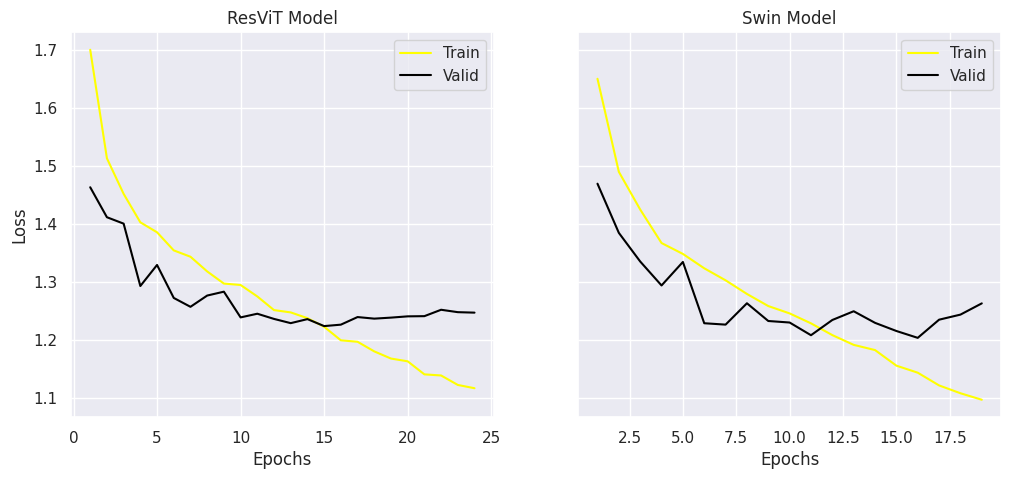

In [ ]:
# plotting loss curves for both models

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# X-axis values based on the actual number of epochs trained
resvit_epochs = range(1, len(resvit_train_losses) + 1)
swin_epochs = range(1, len(swin_train_losses) + 1)


# Plotting Resvit losses
sns.lineplot(x=resvit_epochs, y=resvit_train_losses, color="yellow", label="Train", ax=ax[0])
sns.lineplot(x=resvit_epochs, y=resvit_valid_losses, color="black", label="Valid", ax=ax[0])

ax[0].set(title="ResViT Model", xlabel="Epochs", ylabel="Loss")
ax[0].legend()

# Plotting Swin losses
sns.lineplot(x=swin_epochs, y=swin_train_losses, color="yellow", label="Train", ax=ax[1])
sns.lineplot(x=swin_epochs, y=swin_valid_losses, color="black", label="Valid", ax=ax[1])

ax[1].set(title="Swin Model", xlabel="Epochs", ylabel="Loss")
ax[1].legend()

plt.show()

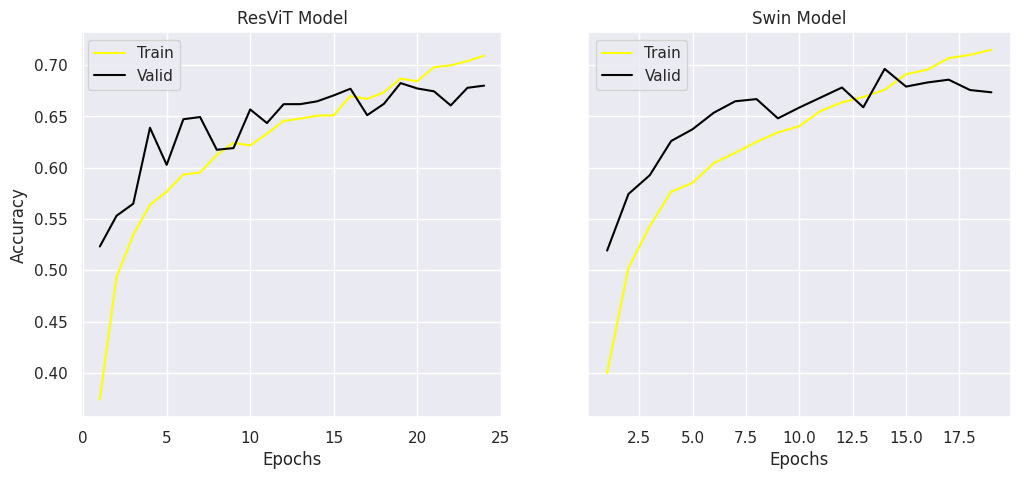

In [ ]:
# Plotting the accuracies for both model

sns.set_theme(style='darkgrid')
fig, ax1 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

epochs = range(1, num_epochs + 1)

# Plotting resvit accuracies
sns.lineplot(x=resvit_epochs, y=resvit_train_acc, color="yellow", label="Train", ax=ax1[0])
sns.lineplot(x=resvit_epochs, y=resvit_valid_acc, color="black", label="Valid", ax=ax1[0])

ax1[0].set(title="ResViT Model", xlabel="Epochs", ylabel="Accuracy")
ax1[0].legend()

# Plotting swin accuracies
sns.lineplot(x=swin_epochs, y=swin_train_acc, color="yellow", label="Train", ax=ax1[1])
sns.lineplot(x=swin_epochs, y=swin_valid_acc, color="black", label="Valid", ax=ax1[1])

ax1[1].set(title="Swin Model", xlabel="Epochs", ylabel="Accuracy")
ax1[1].legend()

plt.show()


In [ ]:
# Define Testing Function

def testing_model_fn(model, device, dataloader, num_classes):

     # Initialize metric objects for confusion matrix, precision, recall, and F1 score
    confmat = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)
    precision_metric = torchmetrics.Precision(task='multiclass', num_classes=num_classes, average='none').to(device)
    recall_metric = torchmetrics.Recall(task='multiclass', num_classes=num_classes, average='none').to(device)
    f1_score_metric = torchmetrics.F1Score(task='multiclass', num_classes=num_classes, average='none').to(device)

    # Disable gradient calculation for evaluation (saves memory and computation)
    with torch.no_grad():
        for images, labels in dataloader:
            # Move images and labels to the appropriate device (GPU)
            images, labels = images.to(device), labels.to(device)

            # Forward pass: get model predictions
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class indices

            # Update all metric trackers with current batch results
            confmat.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_score_metric.update(preds, labels)

    # Compute final metrics after all batches are processed
    confusion_matrix = confmat.compute()
    test_precision = precision_metric.compute()
    test_recall = recall_metric.compute()
    test_f1_score = f1_score_metric.compute()

    return confusion_matrix, test_precision, test_recall, test_f1_score


In [ ]:
# --- Evaluation for ResViT ---

# Load the best ResViT model checkpoint
resvit_checkpoint = torch.load(resvit_save_path)
resvit_model.load_state_dict(resvit_checkpoint['model_state_dict'])

resvit_confusion_matrix, resvit_test_precision, resvit_test_recall, resvit_test_f1_score = testing_model_fn(
    model=resvit_model,
    device=device,
    dataloader=test_dataloader,
    num_classes=8
)

In [ ]:
# --- Evaluation for Swin ---

# Load the best Swin model checkpoint
swin_checkpoint = torch.load(swin_save_path)
swin_model.load_state_dict(swin_checkpoint['model_state_dict'])

swin_confusion_matrix, swin_test_precision, swin_test_recall, swin_test_f1_score = testing_model_fn(
    model=swin_model,
    device=device,
    dataloader=test_dataloader,
    num_classes=8
)

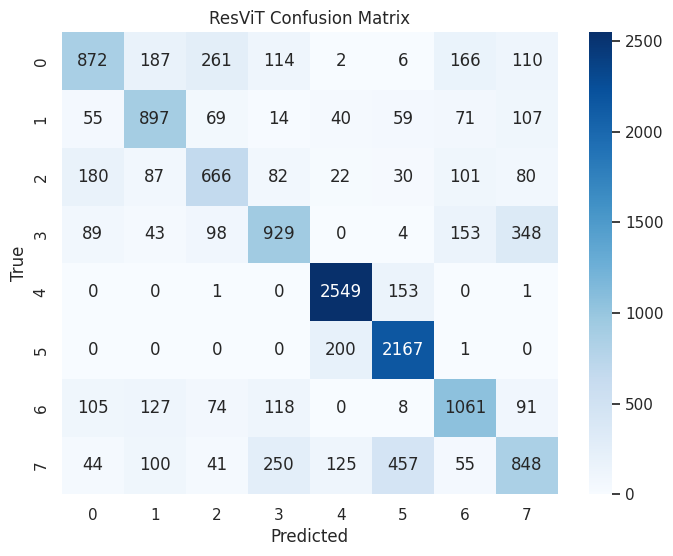

In [ ]:
# plot confusion matrix for ResViT
plt.figure(figsize=(8, 6))
sns.heatmap(resvit_confusion_matrix.cpu().numpy(), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResViT Confusion Matrix')
plt.show()


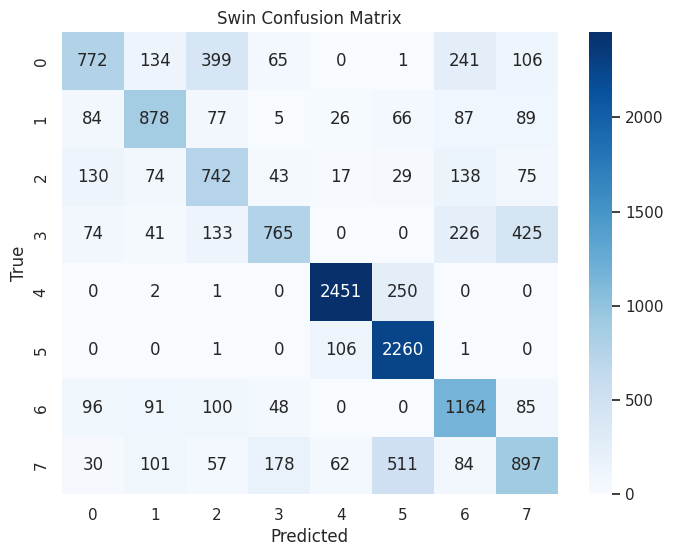

In [ ]:
# plot confusion matrix for Swin
plt.figure(figsize=(8, 6))
sns.heatmap(swin_confusion_matrix.cpu().numpy(), annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Swin Confusion Matrix')
plt.show()

In [ ]:
print(f'Resvit Precision: {resvit_test_precision}')
print(f'Resvit Recall: {resvit_test_recall}')
print(f'Resvit F1 Score: {resvit_test_f1_score}')


Resvit Precision: tensor([0.6483, 0.6225, 0.5504, 0.6165, 0.8676, 0.7514, 0.6598, 0.5350],
       device='cuda:0')
Resvit Recall: tensor([0.5076, 0.6837, 0.5337, 0.5583, 0.9427, 0.9151, 0.6698, 0.4417],
       device='cuda:0')
Resvit F1 Score: tensor([0.5694, 0.6517, 0.5419, 0.5859, 0.9036, 0.8252, 0.6648, 0.4839],
       device='cuda:0')


In [ ]:
print(f'swin precision: {swin_test_precision}')
print(f'swin recall: {swin_test_recall}')
print(f'swin f1 score: {swin_test_f1_score}')


swin precision: tensor([0.6509, 0.6646, 0.4914, 0.6929, 0.9207, 0.7251, 0.5997, 0.5349],
       device='cuda:0')
swin recall: tensor([0.4494, 0.6692, 0.5946, 0.4597, 0.9064, 0.9544, 0.7348, 0.4672],
       device='cuda:0')
swin f1 score: tensor([0.5317, 0.6669, 0.5381, 0.5527, 0.9135, 0.8241, 0.6604, 0.4987],
       device='cuda:0')


**ABLATION STUDY**

In [ ]:
# 1. Without Data augmentation

# Just preprocessing no augmenting
transforms = v2.Compose([
    v2.Resize(128),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Get Train data with preprocessing transforms
total_train = ImageFolder(root=train_root, transform=transforms)

# set train and test sizes
train_size = int(0.8 * len(total_train))
val_size = len(total_train) - train_size

# Set a seed for reproducibility
generator = torch.Generator().manual_seed(42)

# splits
train_subset, valid_subset = random_split(total_train, [train_size, val_size], generator=generator)

train_dataloader_no_aug = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_dataloader_no_aug = DataLoader(valid_subset, batch_size=batch_size)

# Initialize a new model instance
resvit_model_no_aug = HybridResViT().to(device)

# Define optimizer and scheduler
resvit_optimizer_no_aug = torch.optim.Adam(resvit_model_no_aug.parameters(), lr=1e-4)
resvit_scheduler_no_aug = torch.optim.lr_scheduler.CosineAnnealingLR(resvit_optimizer_no_aug, T_max=num_epochs, eta_min=1e-6)

# Define critirion
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device), label_smoothing=0.1)

resvit_train_losses_no_aug, resvit_valid_losses_no_aug, resvit_train_acc_no_aug, resvit_valid_acc_no_aug = train_and_validate_model_fn(
    model=resvit_model_no_aug,
    device=device,
    train_dataloader=train_dataloader_no_aug,
    valid_dataloader=valid_dataloader_no_aug,
    optimizer=resvit_optimizer_no_aug,
    scheduler=resvit_scheduler_no_aug,
    num_epochs=num_epochs,
    criterion=criterion,
    patience=patience,
    model_name='ResViT(No_Aug)'
)

ResViT(No_Aug) | Train Loss: 0.5350 | Train Acc: 98.66% | Val Loss: 1.5846 | Val Acc: 64.42%
Early stopping triggered at Epoch: 13

Training completed in 511.81 seconds.


In [ ]:
# ResVIt Model Training without Weighted Loss and Label smoothing
# ---------------------------------------------------------------

# Initialize a new model instance
resvit_model_no_weight = HybridResViT().to(device)

resvit_optimizer_no_weight = torch.optim.Adam(resvit_model_no_weight.parameters(), lr=1e-4)
resvit_scheduler_no_weight = torch.optim.lr_scheduler.CosineAnnealingLR(resvit_optimizer_no_weight, T_max=num_epochs, eta_min=1e-6)


# Define loss function without class weights and label smoothing
criterion = nn.CrossEntropyLoss()

# Call the train_and_evaluate_model function
resvit_train_losses_no_weight, resvit_valid_losses_no_weight, resvit_train_acc_no_weight, resvit_valid_acc_no_weight = train_and_validate_model_fn(
    model=resvit_model_no_aug,
    device=device,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=resvit_optimizer_no_weight,
    scheduler=resvit_scheduler_no_weight,
    num_epochs=num_epochs,
    criterion=criterion,
    patience=patience,
    model_name='ResViT(No_Weight)'
)

ResViT(No_Weight) | Train Loss: 1.9585 | Train Acc: 42.32% | Val Loss: 1.4301 | Val Acc: 59.51%
Early stopping triggered at Epoch: 12

Training completed in 889.15 seconds.


In [ ]:
# Resnet34 standalone

# Initialize a new model instance
resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1).to(device)

resnet.fc = nn.Linear(resnet.fc.in_features, 8).to(device)

resnet_optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
resnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(resnet_optimizer, T_max=num_epochs, eta_min=1e-6)

# Define loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device), label_smoothing=0.1)

resnet_train_losses, resnet_valid_losses, resnet_train_acc, resnet_valid_acc = train_and_validate_model_fn(
    model=resnet,
    device=device,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=resnet_optimizer,
    scheduler=resnet_scheduler,
    num_epochs=num_epochs,
    criterion=criterion,
    patience=patience,
    model_name='Resnet34'
)

Resnet34 | Train Loss: 1.2506 | Train Acc: 64.23% | Val Loss: 1.2507 | Val Acc: 64.76%
Early stopping triggered at Epoch: 12

Training completed in 860.63 seconds.
